In [11]:
pip install kagglehub

100%|██████████████████████████████████████████████████████████████████████████████| 87.9k/87.9k [00:00<00:00, 179kB/s]

Extracting files...


Path to dataset files: C:\Users\HP\.cache\kagglehub\datasets\d4rklucif3r\full-scale-waste-water-treatment-plant-data\versions\1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                1382 non-null   int64  
 1   Average Outflow           1382 non-null   float64
 2   Average Inflow            1382 non-null   float64
 3   Energy Consumption        1382 non-null   float64
 4   Ammonia                   1382 non-null   float64
 5   Biological Oxygen Demand  1382 non-null   float64
 6   Chemical Oxygen Demand    1382 non-null   float64
 7   Total Nitrogen            1382 non-null   float64
 8   Average Temperature       1382 non-null   float64
 9   Maximum temperature       1382 non-null   float64
 10  Minimum temperature       1382 non-null   float64
 11  Atmospheric pressure      1382 non-null   flo

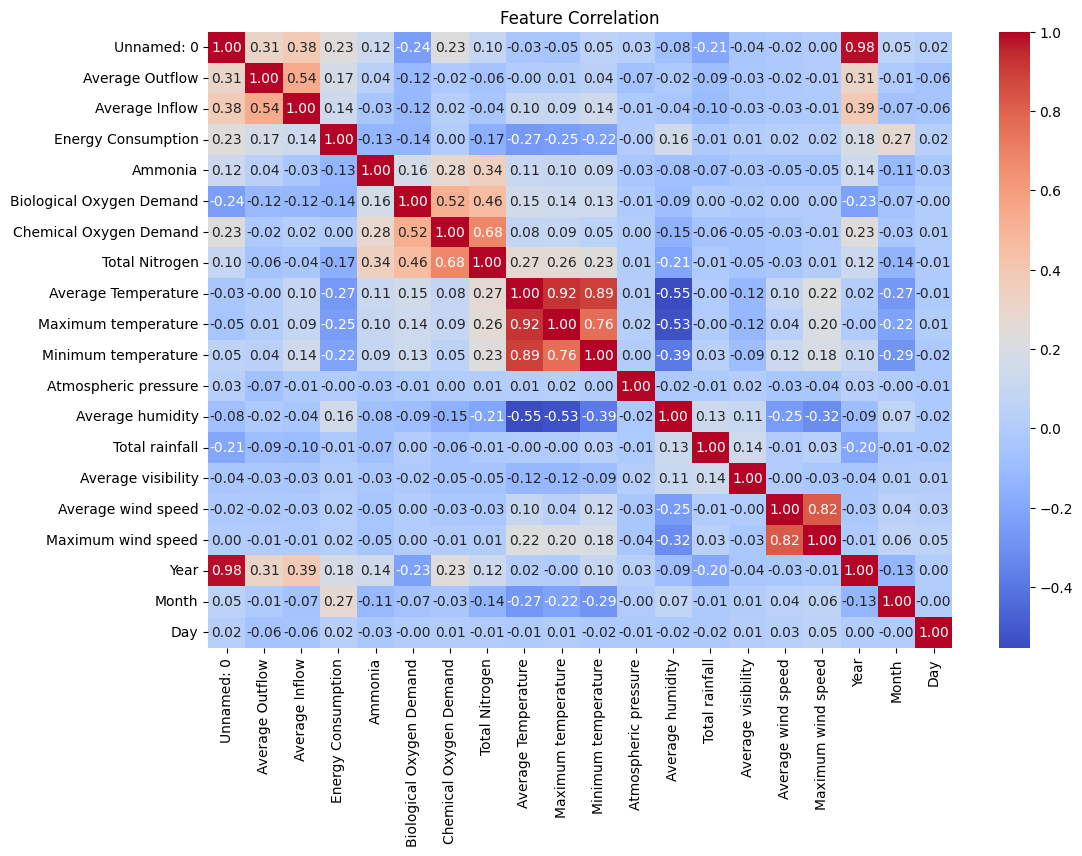

KeyError: 'Optimal_State'

In [12]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Download the dataset using kagglehub
path = kagglehub.dataset_download("d4rklucif3r/full-scale-waste-water-treatment-plant-data")
print("Path to dataset files:", path)

# Load the specific dataset file
file_path = f"{path}/Data-Melbourne_F_fixed.csv"

# Load the dataset
data = pd.read_csv(file_path)

# Correct first-row formatting (add "Serial No" if needed)
if data.columns[0] == "":
    data.columns.values[0] = "Serial No"

# Data Overview
print(data.info())
print(data.describe())

# Handle Missing Values
imputer = SimpleImputer(strategy='mean')
data.iloc[:, 1:] = imputer.fit_transform(data.iloc[:, 1:])

# Visualize Correlations
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

# Feature Selection (drop less relevant features, example given)
# Drop features with low correlation with target (modify based on analysis)
correlation_threshold = 0.1
target = 'Optimal_State'  # Replace with the actual target column name
features = data.corr()[target].abs()
selected_features = features[features > correlation_threshold].index
data = data[selected_features]

# Splitting Data
X = data.drop(target, axis=1)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Logistic Regression from Scratch
class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        self.m, self.n = X.shape
        self.weights = np.zeros(self.n)
        self.bias = 0
        y = y.values if isinstance(y, pd.Series) else y

        for _ in range(self.iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)
            dw = (1 / self.m) * np.dot(X.T, (y_predicted - y))
            db = (1 / self.m) * np.sum(y_predicted - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return [1 if i > 0.5 else 0 for i in y_predicted]

# Train Logistic Regression from scratch
log_reg_scratch = LogisticRegressionScratch()
log_reg_scratch.fit(X_train, y_train)
y_pred_scratch = log_reg_scratch.predict(X_test)
print("Logistic Regression (Scratch) Accuracy:", accuracy_score(y_test, y_pred_scratch))

# Logistic Regression (Sklearn)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Model Evaluation
models = {
    "Logistic Regression (Sklearn)": y_pred_lr,
    "K-Nearest Neighbors": y_pred_knn,
    "Decision Tree": y_pred_dt,
    "Random Forest": y_pred_rf,
    "Support Vector Machine": y_pred_svm
}

for name, preds in models.items():
    print(f"{name} Accuracy: {accuracy_score(y_test, preds):.4f}")
    print(f"{name} F1 Score: {f1_score(y_test, preds):.4f}")
    print(f"{name} Confusion Matrix:\n{confusion_matrix(y_test, preds)}\n")

# Hyperparameter Tuning Example (Random Forest)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

print("Best Random Forest Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("Best Random Forest F1 Score:", f1_score(y_test, y_pred_best_rf))
